In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sys
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from ml_datasets.esl import ProstateCancer

In [2]:
prostate_cancer = ProstateCancer(force=True)

In [3]:
df = prostate_cancer.load()

Retrieving ESL-Mixture dataset...
from https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data to C:\Users\mzyskk\AppData\Local\Temp\ESL\prostate.data


7.17kiB [00:00, 2.42MiB/s]                                                                                             


from https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.info.txt to C:\Users\mzyskk\AppData\Local\Temp\ESL\prostate.info.txt


1.02kiB [00:00, 347kiB/s]                                                                                              


In [4]:
print(prostate_cancer.info)

Prostate data info

Predictors (columns 1--8)

lcavol
lweight
age
lbph
svi
lcp
gleason
pgg45

outcome (column 9)

lpsa

train/test indicator (column 10)

This last column indicates which 67 observations were used as the 
"training set" and which 30 as the test set, as described on page 48
in the book.

There was an error in these data in the first edition of this
book. Subject 32 had a value of 6.1 for lweight, which translates to a
449 gm prostate! The correct value is 44.9 gm. We are grateful to
Prof. Stephen W. Link for alerting us to this error.

The features must first be scaled to have mean zero and  variance 96 (=n)
before the analyses in Tables 3.1 and beyond.  That is, if x is the  96 by 8 matrix
of features, we compute xp <- scale(x,TRUE,TRUE)




### Scatter-plot Matrix
The book shows the scatterplot matrix of the dataset in Figure 1.1 of Chapter 1. It shows every pairwise plot between the variables.

In [5]:
def format_scatter_plot(axes):
    # iterate through all the subplots
    for i, label in enumerate(column_reordered):
        for j, _ in enumerate(column_reordered):
            if i == j:
                # clear the subplot diagonal and annotate it with label
                axes[i,i].clear()
                axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=15)
            ax = axes[i, j]
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.yaxis.label.set_rotation(90)

            if ax.is_first_col():
                ax.yaxis.set_ticks_position('left')
                plt.sca(ax)
                plt.yticks(rotation=90)

            if ax.is_last_col():
                ax.yaxis.set_ticks_position('right')
                plt.sca(ax)
                plt.yticks(rotation=90)
                if ax.is_last_row():
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            if ax.is_first_row():
                ax.xaxis.set_ticks_position('top')

            if ax.is_last_row():
                ax.xaxis.set_ticks_position('bottom')
                plt.sca(ax)
                plt.xticks(rotation=0)

    for i, j in zip(range(len(column_reordered)), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

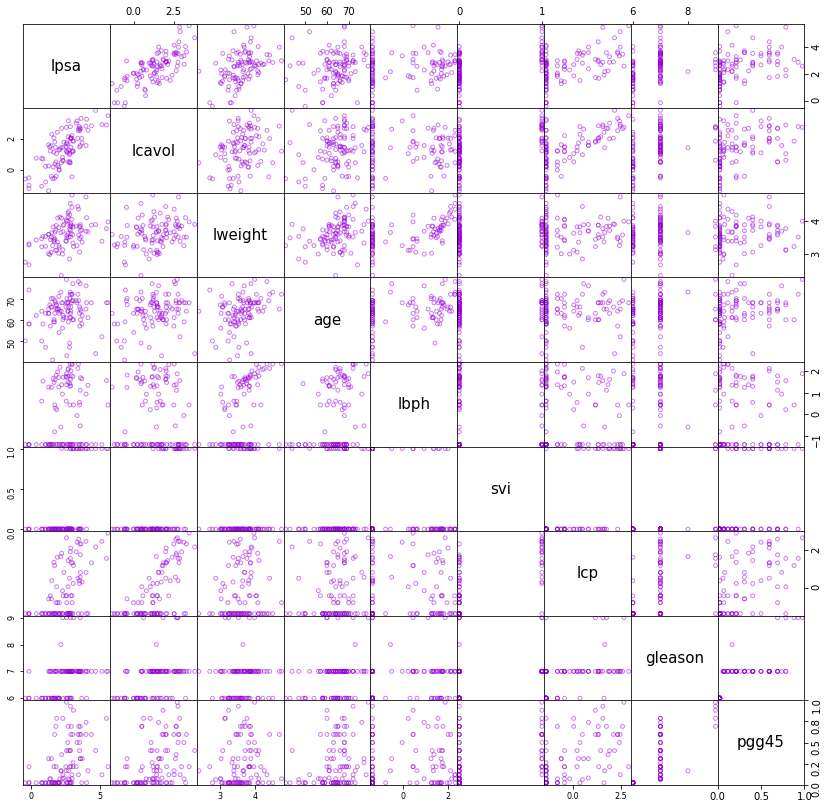

In [6]:
# reordering columns to have identical result as the one in the book
column_reordered = ['lpsa'] + prostate_cancer.meta[:-1]

# plot scatter matrix
axes = pd.plotting.scatter_matrix(df[column_reordered], figsize=(14, 14), marker='o', facecolors="none", edgecolors='#9A03DB', s=15)
format_scatter_plot(axes)
plt.show()

This scatter matrix is almost identical to the one presented in the book.

### Data Extraction
Here, we extract the input and output data frames from the original full dataframe.

In [7]:
# extract input and output dataframe
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

### Scaling
From the info of the dataset, we are required to scale the features to have zero mean and unit variance.
There are some libraries that can do that for us. However, here, I just want to write my own scaling method: 

In [8]:
def scale(x):
    mean = x.values.mean(axis=0, keepdims=True)
    stdev = x.values.std(axis=0, keepdims=True, ddof=0)
    return np.divide(np.subtract(x, mean), stdev)

In [9]:
df_x = df_x.apply(lambda x: scale(x))
df_x.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.645861,-2.016634,-1.872101,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
1,-1.999313,-0.725759,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
2,-1.587021,-2.200154,1.368234,-1.030029,-0.525657,-0.867655,0.344407,-0.156155
3,-2.178174,-0.812191,-0.791989,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957
4,-0.510513,-0.461218,-0.251933,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957


In [10]:
df_y.head()

0   -0.430783
1   -0.162519
2   -0.162519
3   -0.162519
4    0.371564
Name: lpsa, dtype: float64

### Correlation of Predictors
The following code plots the correlation of predictors in the prostate cancer data. Necessary formatting and dropping are done to have identical result as the one shown in TABLE 3.1 in the book.

In [11]:
corr_table = df_x[train_test=='T'].corr(method='pearson').drop('lcavol').drop('pgg45', axis=1).apply(lambda x: x.map('{:.3f}'.format))
corr_table.where(np.tril(np.ones(corr_table.shape)).astype(np.bool)).replace(np.nan, '', regex=True)

,lcavol,lweight,age,lbph,svi,lcp,gleason
lweight,0.300,,,,,,
age,0.286,0.317,,,,,
lbph,0.063,0.437,0.287,,,,
svi,0.593,0.181,0.129,-0.139,,,
lcp,0.692,0.157,0.173,-0.089,0.671,,
gleason,0.426,0.024,0.366,0.033,0.307,0.476,
pgg45,0.483,0.074,0.276,-0.030,0.481,0.663,0.757


This table is identical to the one in the book.

### Least Squares Regression

In [12]:
class LeastSquaresRegression:
    def fit(self, x, y):
        self.y = y
        # append intercept in the input x, so x = [1, x1, x2]
        x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
        
        # check if dot(x.T, x) is invertible
        if self._check_condition(x) == 1:
            xtx = x.T @ x
            xtx_inv = np.linalg.inv(xtx)
            self.beta_hat = xtx_inv @ x.T @ self.y
    
    def _check_condition(self, x):
        xtx = x.T @ x
        if np.linalg.cond(xtx) < 1/sys.float_info.epsilon:
            xtx_inv = np.linalg.inv(xtx)
            return 1
        else:
            print("dot(x.T, x) is ill-conditioned")
            sys.exit()
        
    def calculate_z(self, x, y):
        # use (1 / (x.shape[0] - x.shape[1])) instead of (1 / (x.shape[0] - x.shape[1] - 1))
        # since it already includes the intercept
        x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
        if self._check_condition(x) == 1:
            xtx = x.T @ x
            xtx_inv = np.linalg.inv(xtx)
        
        self.variance_hat = (1 / (x.shape[0] - x.shape[1])) * np.sum((y - x @ self.beta_hat) ** 2)
        self.beta_hat_var = np.sqrt(np.diag(xtx_inv) * self.variance_hat)
        self.z = self.beta_hat / self.beta_hat_var
        
    def predict(self, x):
        x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
        return x @ self.beta_hat
    
    def calculate_f(self, x, y, x0):
        x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
        rss1 = np.sum((y - x @ self.beta_hat) ** 2)
        
        x0 = np.concatenate((np.ones_like(x0[:, 0].reshape(-1, 1)), x0), axis=1)
        if self._check_condition(x) == 1:
            xtx0 = x0.T @ x0
            xtx0_inv = np.linalg.inv(xtx0)
            beta_hat_0 = xtx0_inv @ x0.T @ self.y
            
        rss0 = np.sum((y - x0 @ beta_hat_0) ** 2)
        self.F = ((rss0 - rss1) / (x.shape[1] - x0.shape[1])) / (rss1/ (len(y) - x.shape[1]))
        self.dfn = (x.shape[1] - x0.shape[1])
        self.dfd = (x.shape[0] - x.shape[1])
        self.p_value = 1 - stats.f.cdf(self.F, dfn=self.dfn, dfd=self.dfd)
        

In [13]:
x_train = df_x[train_test=='T'].values
y_train =  df_y[train_test=='T'].values
lsreg = LeastSquaresRegression()
lsreg.fit(x_train, y_train)

In [14]:
# calculate Z score

lsreg.calculate_z(x_train, y_train)
# create the Z score table
df_zscore = pd.DataFrame(
    {
        'Term': ["Intercept"] + prostate_cancer.meta[:-1], 
        "Coefficient": lsreg.beta_hat, 
        "Std. Error": lsreg.beta_hat_var, 
        "Z Score": lsreg.z
    }
).set_index('Term', drop=True)

# format floats to show only 2 digits precision
df_zscore.apply(lambda x: x.map('{:,.2f}'.format))

,Coefficient,Std. Error,Z Score
Term,,,
Intercept,2.46,0.09,27.60
lcavol,0.68,0.13,5.37
lweight,0.26,0.10,2.75
age,-0.14,0.10,-1.40
lbph,0.21,0.10,2.06
svi,0.30,0.12,2.47
lcp,-0.29,0.15,-1.87
gleason,-0.02,0.14,-0.15
pgg45,0.27,0.15,1.74


In [15]:
# calculate F statistic
x_train_0 = df_x[train_test=='T'].drop(['age', 'lcp', 'gleason', 'pgg45'], axis=1).values
lsreg.calculate_f(x_train, y_train, x_train_0)
print("P(F({}, {}) > {:.2f}) = {:.2f}".format(lsreg.dfn, lsreg.dfd, lsreg.F, lsreg.p_value))

P(F(4, 58) > 1.67) = 0.17


In [18]:
x_test = df_x[train_test=='F'].values
y_test =  df_y[train_test=='F'].values
y_test_hat = lsreg.predict(x_test)
error_base = np.mean((y_test - y_train.mean()) ** 2)
error_ls = np.mean((y_test - y_test_hat) **2)

In [19]:
print("Base error rate = {:.3f}".format(error_base))
print("LS error rate = {:.3f}".format(error_ls))
print("The error is reduced by {:.1f}%".format((error_base - error_ls)/error_base * 100))

Base error rate = 1.057
LS error rate = 0.521
The error is reduced by 50.7%


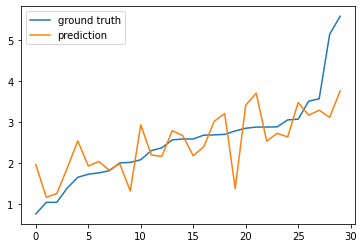

In [24]:
plt.plot(y_test, label='ground truth')
plt.plot(y_test_hat, label='prediction')
plt.legend()
plt.show()